In [1]:
import numpy as np
import FuncParcel
from scipy import stats
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib as mpl
from matplotlib import colors
%matplotlib inline

/Users/kaihwang/bin/brainx/brainx/__init__.py:30: UserWarning: Monkeypatching NetworkX's Watts-Strogatz routine
  warnings.warn("Monkeypatching NetworkX's Watts-Strogatz routine")


# Thalamic Parcellation

In [2]:
#path to files ncessary for parcellation
path_to_adjmat = 'Data/ThalamoCorticalAveMat'
path_to_list_of_subcorticalcortical_ROIs = 'Data/Thalamocortical_ROIs_index'
path_to_list_of_subcortical_voxels = 'Data/Thalamic_voxel_index'
path_to_list_of_cortical_ROIs ='Data/Cortical_ROI_index'
path_to_Cortical_CI = 'Data/MGH_CIv2'

#call function
Thalamocalcortical_Targets, Thalamo_ParcelCIs = FuncParcel.parcel_subcortical_network(path_to_adjmat, \
            path_to_list_of_subcorticalcortical_ROIs, \
            path_to_list_of_subcortical_voxels, path_to_list_of_cortical_ROIs, path_to_Cortical_CI)

True


## Display thalamic parcellation over MNI template

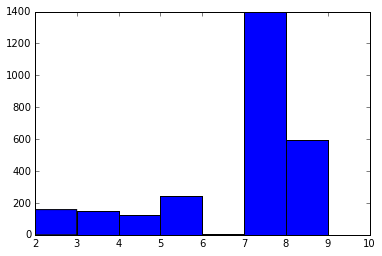

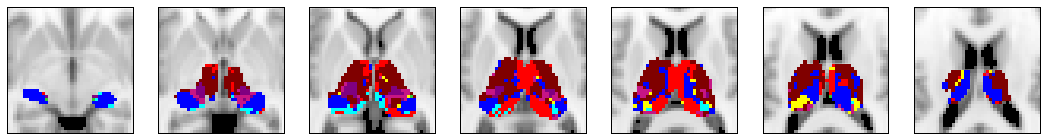

In [52]:
# load subcortical voxel info
Thalamus_voxel_coordinate = np.loadtxt('Data/thalamus_voxel_coordinate_ijk_RPI2mm_scaled', dtype = int)

# sort CI vector
CIs = np.zeros(len(Thalamus_voxel_coordinate))
for i, thalamus_voxel_index in enumerate(Thalamus_voxel_coordinate[:,3]):
   CIs[i]= Thalamo_ParcelCIs[thalamus_voxel_index][0]

# show histogram of CI distribution
CIs = CIs.astype(int)
plt.hist(CIs, bins=np.unique(CIs)+1)
plt.show()


# show volum image
MNI_img = nib.load('Data/MNI152_T1_2mm_brain.nii')
MNI_data = MNI_img.get_data()

# create mask for parcel
Mask = np.zeros(MNI_data.shape)

# assign CI to each subcortical voxel
for i, CI in enumerate(CIs):
    Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i].astype(int)
Mask = np.ma.masked_where(Mask == 0, Mask)

# flip dimension to show anteiror of the brain at top
MNI_data = MNI_data.swapaxes(0,1)
Mask = Mask.swapaxes(0,1)

# some plot setting (colormap), interplotation..
cmap = colors.ListedColormap(['blue', 'cyan', 'purple', 'yellow', 'mediumvioletred', 'limegreen', 'maroon', 'red'])

# display slice by slice
Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2]+1), np.max(Thalamus_voxel_coordinate[:,2]+1),2)
fig = plt.figure()
for i, Z_slice in enumerate(Z_slices):
    a = plt.subplot(1, len(Z_slices), i+1 )
    a.set_yticks([])
    a.set_xticks([])
    plt.imshow(MNI_data[40:80, 25:65, Z_slice], cmap='gray', interpolation='nearest')
    plt.imshow(Mask[40:80, 25:65, Z_slice], cmap=cmap, interpolation='none')
    plt.ylim(plt.ylim()[::-1])
    
fig.set_size_inches(18.5,10.5) 
plt.savefig('Data/Tha_parcel.png', bbox_inches='tight')

In [280]:
# Striatal Parcellation

In [39]:
#path to files ncessary for parcellation
path_to_adjmat = 'Data/StriatalCorticalAveMat'
path_to_list_of_subcorticalcortical_ROIs = 'Data/Striatalcortical_ROIs_index'
path_to_list_of_subcortical_voxels = 'Data/striatal_voxel_index'
path_to_list_of_cortical_ROIs ='Data/Cortical_ROI_index'
path_to_Cortical_CI = 'Data/MGH_CIv2'

#call function
Striatal_Targets, Striatal_ParcelCIs = FuncParcel.parcel_subcortical_network(path_to_adjmat, \
            path_to_list_of_subcorticalcortical_ROIs, \
            path_to_list_of_subcortical_voxels, path_to_list_of_cortical_ROIs, path_to_Cortical_CI)

True


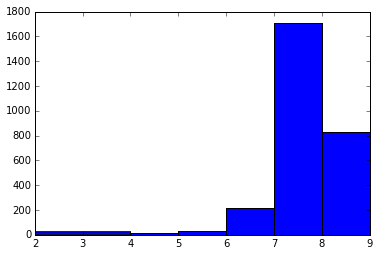

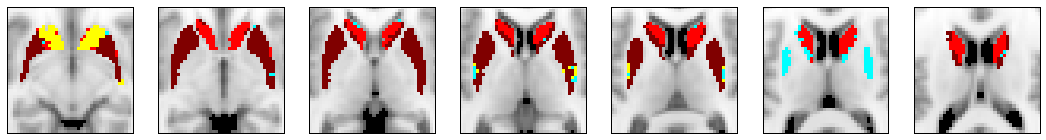

In [53]:
# load subcortical voxel info
Striatal_voxel_coordinate = np.loadtxt('Data/striatal_voxel_coordinate_ijk_RPI2mm_scaled', dtype = int)

# sort CI vector
CIs = np.zeros(len(Striatal_voxel_coordinate))
for i, Striatal_voxel_index in enumerate(Striatal_voxel_coordinate[:,3]):
   CIs[i], _, = stats.mode(Striatal_ParcelCIs[Striatal_voxel_index][0:5])

# show histogram of CI distribution
CIs = CIs.astype(int)
plt.hist(CIs, bins=np.unique(CIs)+1)
plt.show()


# show volum image
MNI_img = nib.load('Data/MNI152_T1_2mm_brain.nii')
MNI_data = MNI_img.get_data()

# create mask for parcel
Mask = np.zeros(MNI_data.shape)

# assign CI to each subcortical voxel
for i, CI in enumerate(CIs):
    Mask[Striatal_voxel_coordinate[i,0], Striatal_voxel_coordinate[i,1], Striatal_voxel_coordinate[i,2]] = CIs[i].astype(int)
Mask = np.ma.masked_where(Mask == 0, Mask)


# flip dimension to show anteiror of the brain at top
MNI_data = MNI_data.swapaxes(0,1)
Mask = Mask.swapaxes(0,1)

# some plot setting (colormap), interplotation..
cmap = colors.ListedColormap(['blue', 'cyan', 'purple', 'yellow', 'mediumvioletred', 'limegreen', 'maroon', 'red'])

# display slice by slice
Z_slices = range(np.min(Striatal_voxel_coordinate[:,2]+3), np.max(Striatal_voxel_coordinate[:,2]-3),2)
fig = plt.figure()
for i, Z_slice in enumerate(Z_slices):
    a = plt.subplot(1, len(Z_slices), i+1 )
    a.set_yticks([])
    a.set_xticks([])
    plt.imshow(MNI_data[40:80, 25:65, Z_slice], cmap='gray', interpolation='nearest')
    plt.imshow(Mask[40:80, 25:65, Z_slice], cmap=cmap, interpolation='nearest')
    plt.ylim(plt.ylim()[::-1])
    
fig.set_size_inches(18.5,10.5) 
plt.savefig('Data/Striatal_parcel.png',bbox_inches='tight')